# This notebook is to do experiments on performance of EfficientNetV2B3 with transfer learning

keras.applications.EfficientNetV2B3

### Scenarios 

1. Feature extraction with 10 percent train data
2. Feature extration with 10 percent train data with data augmentation
3. Feature extraction + fine tuning + 10 percent train data + data augmentation
4. Feature extraction + fine tuning + full train data + data augmentation
5. Feature extraction with full train data

In [1]:
import tensorflow as tf 
import keras 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os  
import pathlib 
from keras import layers

In [2]:
scenarios = {
    "scenario_1": {
        "name": "model_0",
        "data": "ten_percent", 
        "data_augmentation": False, 
        "fine_tuning": False
    }, 
    "scenario_2": {
        "name": "model_1",
        "data": "ten_percent", 
        "data_augmentation": True, 
        "fine_tuning": False
    },
    "scenario_3": {
        "name": "model_1",
        "data": "ten_percent", 
        "data_augmentation": True,
        "fine_tuning": True
    },
    "scenario_4": {
        "name": "model_1",
        "data": "full_data", 
        "data_augmentation": True,
        "fine_tuning": True
    },
    "scenario_5": {
        "name": "model_0",
        "data": "full", 
        "data_augmentation": False,
        "fine_tuning": False
    }
}

In [3]:
scenarios_df = pd.DataFrame(scenarios).T

In [4]:
scenarios_df.columns

Index(['name', 'data', 'data_augmentation', 'fine_tuning'], dtype='object')

In [5]:
# discover data 
one_percent_train_dir = "data/10_food_classes_1_percent/train/" 
one_percent_test_dir = "data/10_food_classes_1_percent/test/" 

ten_percent_train_dir = "data/10_food_classes_10_percent/train/"
ten_percent_test_dir = "data/10_food_classes_10_percent/test/" 

full_train_dir = "data/10_food_classes_all_data/train/"
full_test_dir = "data/10_food_classes_all_data/test/"

In [6]:
# discover data 

for directory, folders, files in os.walk("data/10_food_classes_1_percent/"): 
    print(f"There are {len(folders)} folders and {len(files)} files in '{directory}'")

There are 2 folders and 0 files in 'data/10_food_classes_1_percent/'
There are 10 folders and 0 files in 'data/10_food_classes_1_percent/test'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/chicken_curry'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/chicken_wings'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/fried_rice'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/grilled_salmon'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/hamburger'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/ice_cream'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/pizza'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/ramen'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/steak'
There are 0 folders and 250 files in 'data/10_food_classes_1_percent/test/sushi'
There are

In [7]:
# Prepare test data 
IMG_SIZE = (300, 300) 
BATCH_SIZE = 32

one_percent_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=one_percent_train_dir, 
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=42
)

one_percent_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=one_percent_test_dir, 
    label_mode="categorical", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    seed=42
) 

ten_percent_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=ten_percent_train_dir, 
    label_mode="categorical", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    seed=42
) 


ten_percent_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=ten_percent_test_dir, 
    label_mode="categorical", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    seed=42
) 

full_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=full_train_dir, 
    label_mode="categorical", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    seed=42
)

full_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=full_test_dir, 
    label_mode="categorical", 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE, 
    seed=42
)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.
Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [8]:
# Create callbacks 
import datetime
def create_tensorboard_callback(experiment_name, dir_name="logs/tensorboard"): 
    log_dir = os.path.join(
        dir_name, 
        experiment_name, 
        datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    )

    tensorboard_callback = keras.callbacks.TensorBoard(
        log_dir=log_dir
    )
    return tensorboard_callback

def create_model_checkpoint_callback(experiment_name, dir_name="logs/model_checkpoints"): 
    log_dir = os.path.join(
        dir_name, 
        experiment_name, 
        "ckpt-epoch{epoch:02d}.weights.h5"
    )

    model_checkpoints_callback = keras.callbacks.ModelCheckpoint(
        filepath=log_dir,
        monitor='val_loss',
        save_weights_only=True,
        save_freq='epoch', 
        verbose=1
    )

    return model_checkpoints_callback

In [9]:
# Model-1
INPUT_SHAPE = (300, 300, 3)

base_model = keras.applications.EfficientNetV2B3(include_top=False) 
base_model.trainable = False 

inputs = keras.Input(shape=INPUT_SHAPE, name="input_layer") 
x = base_model(inputs, training=False) 
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x) 
outputs = keras.layers.Dense(10, activation="softmax", name="output_layer")(x) 

model_0 = keras.Model(inputs, outputs, name="scenario_1") 

model_0.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(), 
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy")
    ]
) 

model_0.summary()

Model: "scenario_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 10, 10, 1536)   │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,945,992 (49.39 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [10]:
# fit model 
history_0 = model_0.fit(
                ten_percent_test_ds, 
                validation_data=ten_percent_test_ds, 
                validation_steps=int(0.25 * (len(ten_percent_test_ds))), 
                epochs=5, 
                callbacks=[
                    create_tensorboard_callback(
                        experiment_name="10_percent"), 
                    create_model_checkpoint_callback(
                        experiment_name="10_percent"
                    )
                ],
                verbose=2
            )

Epoch 1/5

Epoch 1: saving model to logs/model_checkpoints/10_percent/ckpt-epoch01.weights.h5
79/79 - 50s - 635ms/step - accuracy: 0.7396 - loss: 1.0286 - val_accuracy: 0.8766 - val_loss: 0.4670
Epoch 2/5

Epoch 2: saving model to logs/model_checkpoints/10_percent/ckpt-epoch02.weights.h5
79/79 - 5s - 65ms/step - accuracy: 0.8728 - loss: 0.4758 - val_accuracy: 0.8997 - val_loss: 0.3682
Epoch 3/5

Epoch 3: saving model to logs/model_checkpoints/10_percent/ckpt-epoch03.weights.h5
79/79 - 5s - 65ms/step - accuracy: 0.8940 - loss: 0.3718 - val_accuracy: 0.9095 - val_loss: 0.3108
Epoch 4/5

Epoch 4: saving model to logs/model_checkpoints/10_percent/ckpt-epoch04.weights.h5
79/79 - 5s - 66ms/step - accuracy: 0.9072 - loss: 0.3234 - val_accuracy: 0.9326 - val_loss: 0.2522
Epoch 5/5

Epoch 5: saving model to logs/model_checkpoints/10_percent/ckpt-epoch05.weights.h5
79/79 - 8s - 104ms/step - accuracy: 0.9104 - loss: 0.2923 - val_accuracy: 0.9412 - val_loss: 0.1931


In [11]:
results_scenario_1 = model_0.evaluate(ten_percent_test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9387 - loss: 0.2206


<Axes: >

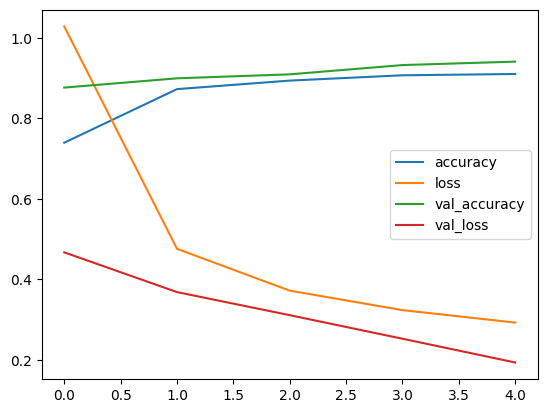

In [12]:
pd.DataFrame(history_0.history).plot()

In [13]:
scenarios_df

,name,data,data_augmentation,fine_tuning
scenario_1,model_0,ten_percent,False,False
scenario_2,model_1,ten_percent,True,False
scenario_3,model_1,ten_percent,True,True
scenario_4,model_1,full_data,True,True
scenario_5,model_0,full,False,False


In [14]:
# Scenario-1 

data_augmentation = keras.Sequential(
    [
        # Geometric transforms
        layers.RandomFlip("horizontal"),  # vertical flip can hurt many real-world datasets
        layers.RandomRotation(0.15),
        layers.RandomTranslation(
            height_factor=0.15,
            width_factor=0.15
        ),
        layers.RandomZoom(
            height_factor=(-0.2, 0.2),
            width_factor=(-0.2, 0.2)
        ),

        # Photometric transforms
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.15),

        # Regularization via noise
        layers.GaussianNoise(0.05),
    ],
    name="data_augmentation"
)

base_model = keras.applications.EfficientNetV2B3(include_top=False) 
base_model.trainable = False 

inputs = keras.Input(shape=INPUT_SHAPE, name="input_layer") 
x = data_augmentation(inputs) 
x = base_model(x, training=False) 
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2d")(x) 
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x) 

model_1 = keras.Model(inputs, outputs, name="scneario_2") 

model_1.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(), 
    metrics=["accuracy"]
)

model_1.summary()



Model: "scneario_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 10, 10, 1536)   │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,945,992 (49.39 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

In [15]:
history_1 = model_1.fit(
    ten_percent_train_ds, 
    validation_data=ten_percent_test_ds, 
    validation_steps=int(0.25 * (len(ten_percent_test_ds))), 
    callbacks=[
        create_tensorboard_callback(
            experiment_name="10_percent_aug"
        ),  
        create_model_checkpoint_callback(
            experiment_name="10_percent_aug"
        )
    ], 
    epochs=5, 
    verbose=1
)

Epoch 1/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.1981 - loss: 2.2005
Epoch 1: saving model to logs/model_checkpoints/10_percent_aug/ckpt-epoch01.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 26s 435ms/step - accuracy: 0.2030 - loss: 2.1932 - val_accuracy: 0.6497 - val_loss: 1.4547
Epoch 2/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.6528 - loss: 1.4342
Epoch 2: saving model to logs/model_checkpoints/10_percent_aug/ckpt-epoch02.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 181ms/step - accuracy: 0.6524 - loss: 1.4287 - val_accuracy: 0.7664 - val_loss: 0.9409
Epoch 3/5
23/24 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - accuracy: 0.6801 - loss: 1.1361
Epoch 3: saving model to logs/model_checkpoints/10_percent_aug/ckpt-epoch03.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 4s 182ms/step - accuracy: 0.6817 - loss: 1.1310 - val_accuracy: 0.7944 - val_loss: 0.7770
Epoch 4/5
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.7721 - loss: 0.9225
Epoch 4: saving model to logs/model_checkpoints/10

In [16]:
results_scenario_2 = model_1.evaluate(ten_percent_test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 77ms/step - accuracy: 0.8294 - loss: 0.5700


In [17]:
# Scenario-3 details 
scenarios_df.iloc[2]

name                     model_1
data                 ten_percent
data_augmentation           True
fine_tuning                 True
Name: scenario_3, dtype: object

In [18]:
## Scenario-3

model_1.load_weights("logs/model_checkpoints/10_percent_aug/ckpt-epoch05.weights.h5")

In [19]:
results_loaded_scenario_2 = model_1.evaluate(ten_percent_test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.8292 - loss: 0.5786


In [20]:
results_scenario_2

[0.5890893340110779, 0.8339999914169312]

In [21]:
results_loaded_scenario_2

[0.5890895128250122, 0.8339999914169312]

In [22]:
np.isclose(np.array(results_scenario_2), np.array(results_loaded_scenario_2))

array([ True,  True])

In [23]:
# Set base_model.trainable=True 

for i, layer in enumerate(model_1.layers): 
    print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b3 False
3 global_average_pooling_2d True
4 output_layer True


In [24]:
model_1.layers[2].trainable = True

for layer in model_1.layers[2].layers[:-10]: 
    layer.trainable = False 

# for i, layer in enumerate(model_1.layers[2].layers): 
#     print(1, layer.name, layer.trainable)

print(f"Number of trainable layers in base_model : {len(model_1.layers[2].trainable_variables)}")

model_1.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=["accuracy"]
)

Number of trainable layers in base_model : 10


In [25]:
for i, layer in enumerate(model_1.layers): 
    print(i, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetv2-b3 True
3 global_average_pooling_2d True
4 output_layer True


In [26]:
initial_epochs = history_1.epoch[-1] + 1
fine_tune_epochs = initial_epochs + 5

history_2 = model_1.fit(
    ten_percent_train_ds, 
    validation_data=ten_percent_test_ds, 
    validation_steps=int(0.25 * (len(ten_percent_test_ds))), 
    callbacks=[
        create_tensorboard_callback(
            experiment_name="10_percent_aug_fine"
        ),  
        create_model_checkpoint_callback(
            experiment_name="10_percent_aug_fine"
        )
    ], 
    initial_epoch=initial_epochs,
    epochs=fine_tune_epochs, 
    verbose=1
)

Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.7866 - loss: 0.9334
Epoch 6: saving model to logs/model_checkpoints/10_percent_aug_fine/ckpt-epoch06.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 24s 375ms/step - accuracy: 0.7859 - loss: 0.9341 - val_accuracy: 0.8470 - val_loss: 0.5920
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.7748 - loss: 0.8703
Epoch 7: saving model to logs/model_checkpoints/10_percent_aug_fine/ckpt-epoch07.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.7749 - loss: 0.8698 - val_accuracy: 0.8388 - val_loss: 0.5626
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7864 - loss: 0.7943
Epoch 8: saving model to logs/model_checkpoints/10_percent_aug_fine/ckpt-epoch08.weights.h5
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 261ms/step - accuracy: 0.7866 - loss: 0.7946 - val_accuracy: 0.8273 - val_loss: 0.5650
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8147 - loss: 0.7441
Epoch 9: saving model to log

In [27]:
results_scenario_3 = model_1.evaluate(ten_percent_test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 79ms/step - accuracy: 0.8639 - loss: 0.4444


In [28]:
results_scenario_2, results_scenario_3

([0.5890893340110779, 0.8339999914169312],
 [0.4639836847782135, 0.8604000210762024])

In [29]:
# Scenario-4
scenarios_df.iloc[3]

name                   model_1
data                 full_data
data_augmentation         True
fine_tuning               True
Name: scenario_4, dtype: object

In [30]:
# load model-1 to pervious stage weights 

model_1.load_weights("logs/model_checkpoints/10_percent_aug/ckpt-epoch05.weights.h5") 

print(f"Number of trainable layers in base_model : {len(model_1.layers[2].trainable_variables)}")


Number of trainable layers in base_model : 10


In [31]:
initial_epochs = history_1.epoch[-1] + 1
fine_tune_epochs = initial_epochs + 5

history_3 = model_1.fit(
    full_train_ds, 
    validation_data=full_test_ds, 
    validation_steps=int(0.25 * (len(full_test_ds))), 
    callbacks=[
        create_tensorboard_callback(
            experiment_name="100_percent_aug_fine"
        ),  
        create_model_checkpoint_callback(
            experiment_name="100_percent_aug_fine"
        )
    ], 
    initial_epoch=initial_epochs,
    epochs=fine_tune_epochs, 
    verbose=1
)

Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.7455 - loss: 0.9415
Epoch 6: saving model to logs/model_checkpoints/100_percent_aug_fine/ckpt-epoch06.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 27s 107ms/step - accuracy: 0.7455 - loss: 0.9411 - val_accuracy: 0.8832 - val_loss: 0.3473
Epoch 7/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8000 - loss: 0.6810
Epoch 7: saving model to logs/model_checkpoints/100_percent_aug_fine/ckpt-epoch07.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.8001 - loss: 0.6808 - val_accuracy: 0.9030 - val_loss: 0.3033
Epoch 8/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.8208 - loss: 0.5855
Epoch 8: saving model to logs/model_checkpoints/100_percent_aug_fine/ckpt-epoch08.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 107ms/step - accuracy: 0.8207 - loss: 0.5856 - val_accuracy: 0.8980 - val_loss: 0.3081
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.8425 - loss: 0.5235
Epoch 9: savi

In [32]:
results_scenario_4 = model_1.evaluate(full_test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 78ms/step - accuracy: 0.9267 - loss: 0.2310


In [33]:
## Scenario-5 fine tune, full data, no data augmentation 

In [34]:
# model_0.load_weights("logs/model_checkpoints/10_percent/ckpt-epoch05.weights.h5")

model_0.summary()

Model: "scenario_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 10, 10, 1536)   │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,976,734 (49.50 MB)

 Trainable params: 15,370 (60.04 KB)

 Non-trainable params: 12,930,622 (49.33 MB)

 Optimizer params: 30,742 (120.09 KB)

In [35]:
## Prepare model_0 for fine tuning 

model_0.layers[1].trainable=True 

for layer in model_0.layers[1].layers[:-10]: 
    layer.trainable = False 

print(f"Number of trainable paramters in base_model : {len(model_0.layers[1].trainable_variables)}")

model_0.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=1e-4), 
    metrics=["accuracy"]
) 

model_0.summary()

Number of trainable paramters in base_model : 10


Model: "scenario_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 300, 300, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-b3 (Functional)  │ (None, 10, 10, 1536)   │    12,930,622 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling_2d       │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 10)             │        15,370 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,945,992 (49.39 MB)

 Trainable params: 861,124 (3.28 MB)

 Non-trainable params: 12,084,868 (46.10 MB)

In [36]:
initial_epochs = history_1.epoch[-1] + 1
fine_tune_epochs = initial_epochs + 5

history_4 = model_0.fit(
    full_train_ds, 
    validation_data=full_test_ds, 
    validation_steps=int(0.25 * (len(full_test_ds))), 
    callbacks=[
        create_tensorboard_callback(
            experiment_name="100_percent_fine"
        ),  
        create_model_checkpoint_callback(
            experiment_name="100_percent_fine"
        )
    ], 
    initial_epoch=initial_epochs,
    epochs=fine_tune_epochs, 
    verbose=1
)

Epoch 6/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.8521 - loss: 0.5020
Epoch 6: saving model to logs/model_checkpoints/100_percent_fine/ckpt-epoch06.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 57s 135ms/step - accuracy: 0.8521 - loss: 0.5019 - val_accuracy: 0.9589 - val_loss: 0.1645
Epoch 7/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.8827 - loss: 0.3772
Epoch 7: saving model to logs/model_checkpoints/100_percent_fine/ckpt-epoch07.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 14s 57ms/step - accuracy: 0.8826 - loss: 0.3772 - val_accuracy: 0.9359 - val_loss: 0.2027
Epoch 8/10
234/235 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.8931 - loss: 0.3441
Epoch 8: saving model to logs/model_checkpoints/100_percent_fine/ckpt-epoch08.weights.h5
235/235 ━━━━━━━━━━━━━━━━━━━━ 13s 57ms/step - accuracy: 0.8931 - loss: 0.3442 - val_accuracy: 0.9359 - val_loss: 0.1812
Epoch 9/10
235/235 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9099 - loss: 0.3082
Epoch 9: saving model to l

In [37]:
results_scenario_5 = model_0.evaluate(full_test_ds)

79/79 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.9595 - loss: 0.1421


In [42]:
results_scenario_1, results_scenario_4, results_scenario_5

([0.22503826022148132, 0.9368000030517578],
 [0.2442256659269333, 0.9223999977111816],
 [0.15520496666431427, 0.9508000016212463])

<Axes: >

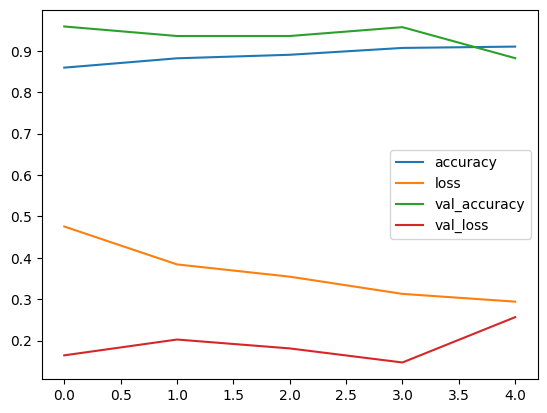

In [45]:
pd.DataFrame(history_4.history).plot()

In [46]:
def plot_combined_history(initial_history, new_history): 
    initial_epochs = initial_history.epoch[-1] 

    acc = initial_history.history['accuracy'] 
    loss = initial_history.history['loss'] 

    val_acc = initial_history.history['val_accuracy'] 
    val_loss = initial_history.history['val_loss'] 


    # combined 

    total_acc = acc + new_history.history['accuracy'] 
    total_loss = loss + new_history.history['loss'] 

    total_val_acc = val_acc + new_history.history['val_accuracy'] 
    total_val_loss = val_loss + new_history.history['val_loss'] 

    # Plot 

    plt.figure(figsize=(10, 10))
    ax = plt.subplot(2, 1, 1) 
    plt.plot(total_acc, label="Training Acc") 
    plt.plot(total_val_acc, label="Validation Acc") 
    plt.plot([initial_epochs, initial_epochs], plt.ylim(), label="Start Fine Tuning")
    plt.legend() 
    plt.title("Traning and Validation Accuracy")

    plt.subplot(2, 1, 2)

    plt.plot(total_loss, label="Train Loss")
    plt.plot(total_val_loss, label="Validation Loss")
    plt.plot([initial_epochs, initial_epochs], plt.ylim(), label="Start Fine Tuning")
    plt.legend()

    plt.title("Traning and Validation Losses")

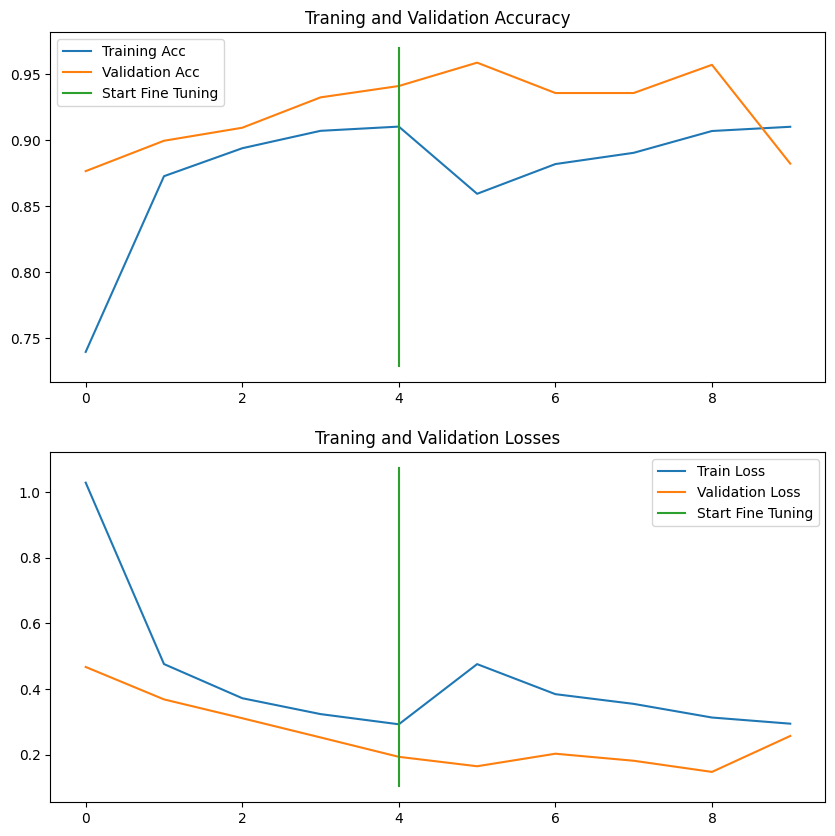

In [47]:
plot_combined_history(history_0, history_4)